# notebook modélisation (consommation d'énergie)

**Objectifs:**

-Nous cherchons à élaborer un modèle de prédiction de la consommation totale d'énergie à partir d'un jeu de données.

Il s'agit donc d'un problème « machine learning » de régression (un problème d'apprentissage supervisé).

-évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d'énerie.

# Importations

In [1040]:
import datetime
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import plotly
import pandas as pd
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
import plotly.express as px
import scipy
from scipy.stats import normaltest
import seaborn as sns
import sklearn
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error,  mean_absolute_percentage_error, r2_score
from sklearn import linear_model
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
import sys
import time
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

In [1041]:
#Chargement des données nettoyées
data = pd.read_csv("building_energy_cleaned.csv")
data.head()

,Unnamed: 0,BuildingType,PrimaryPropertyType,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,ENERGYSTARScore,SiteEnergyUseWN(kBtu)_quartiles,TotalGHGEmissions_quartiles,periode
0,0,NonResidential,Hotel,47.61220,-122.33799,1.0,1.0,88434.0,0.0,88434.0,Hotel,88434.0,7456910.00,0.0,1.0,1.0,159.494,60.0,Q10,Q9,1920-1939
1,1,NonResidential,Hotel,47.61393,-122.33810,1.0,2.2,58895.0,0.0,58895.0,Hotel,57283.0,8081548.90,0.0,1.0,1.0,220.986,43.0,Q10,Q10,1960-1979
2,2,NonResidential,Hotel,47.61412,-122.33664,1.0,1.0,61320.0,0.0,61320.0,Hotel,61320.0,6946800.50,0.0,1.0,1.0,220.246,56.0,Q9,Q10,1920-1939
3,3,Nonresidential COS,Other,47.61623,-122.33657,1.0,2.0,97288.0,0.0,60090.0,Police Station,88830.0,5869715.85,0.0,1.0,1.0,85.558,75.0,Q9,Q8,1980-1999
4,4,NonResidential,Hotel,47.61390,-122.33283,1.0,1.0,83008.0,0.0,83008.0,Hotel,81352.0,6062767.50,0.0,1.0,1.0,176.140,27.0,Q9,Q10,1920-1939


In [1042]:
data.shape

(656, 21)

In [1043]:
if 'Unnamed: 0' in data.columns:
    data.drop('Unnamed: 0', axis=1, inplace=True)

In [1044]:
data.shape

(656, 20)

In [1045]:
#sauvegarde séparée du energy star score
energy_star_score = data['ENERGYSTARScore']
data.drop('ENERGYSTARScore', axis=1, inplace=True)

# Préparation des vecteurs et matrices

**Définition de la "graine"**

**Séparation X et Y**

In [1046]:
ys=data.copy()[{'SiteEnergyUseWN(kBtu)_quartiles'}]
y = data.copy()[{'SiteEnergyUseWN(kBtu)' }]
X = data.copy().drop(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)_quartiles', 'TotalGHGEmissions_quartiles'], axis=1)

In [1047]:
X

,BuildingType,PrimaryPropertyType,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),periode
0,NonResidential,Hotel,47.61220,-122.33799,1.0,1.0,88434.0,0.0,88434.0,Hotel,88434.0,0.0,1.0,1.0,1920-1939
1,NonResidential,Hotel,47.61393,-122.33810,1.0,2.2,58895.0,0.0,58895.0,Hotel,57283.0,0.0,1.0,1.0,1960-1979
2,NonResidential,Hotel,47.61412,-122.33664,1.0,1.0,61320.0,0.0,61320.0,Hotel,61320.0,0.0,1.0,1.0,1920-1939
3,Nonresidential COS,Other,47.61623,-122.33657,1.0,2.0,97288.0,0.0,60090.0,Police Station,88830.0,0.0,1.0,1.0,1980-1999
4,NonResidential,Hotel,47.61390,-122.33283,1.0,1.0,83008.0,0.0,83008.0,Hotel,81352.0,0.0,1.0,1.0,1920-1939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,Nonresidential COS,Other,47.69330,-122.37717,1.0,1.0,11968.0,0.0,11968.0,Prison/Incarceration,11968.0,0.0,1.0,1.0,2000-2019
652,Nonresidential COS,Other,47.72126,-122.29735,1.0,1.0,11285.0,0.0,11285.0,Prison/Incarceration,11285.0,0.0,1.0,1.0,1940-1959
653,Nonresidential COS,Other,47.63228,-122.31574,1.0,1.0,23445.0,0.0,23445.0,Other - Recreation,23445.0,0.0,1.0,1.0,1900-1919
654,Nonresidential COS,Other,47.54067,-122.37441,1.0,1.0,18261.0,0.0,18261.0,Other - Recreation,18261.0,0.0,1.0,1.0,1980-1999


**Normalisation & One Hot Encoder**

In [1048]:
categorical_columns = data[['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType', 'periode']].columns

numerical_columns = data[['Latitude', 'Longitude','NumberofBuildings', 
        'NumberofFloors', 'PropertyGFATotal','PropertyGFAParking', 
        'PropertyGFABuilding(s)','LargestPropertyUseTypeGFA',
        'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']].columns

In [1000]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

ohe = OneHotEncoder(sparse=False)
ss = StandardScaler()
X[numerical_columns] = ss.fit_transform(X[numerical_columns])
ohe.fit_transform(X[categorical_columns])

X = pd.merge(X[numerical_columns], 
          pd.DataFrame(columns = ohe.get_feature_names().tolist(),
              data = ohe.fit_transform(X[categorical_columns])),
        left_index = True, right_index = True)

In [1001]:
X.shape

(656, 87)

Transformation des types des catégories sorties du one hot encoding

In [913]:
import re
regex = re.compile(r'x\d_')
for column in X.columns:
    if regex.search(column):
        X[column] = X[column].astype('int32')

**Séparation du jeu de données(Séparation train/test)**

In [884]:
def equalObs(x, nbin=20):
    nlen = len(x)
    output = np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))
    output = [elt for elt in output if not np.isnan(elt)]
    output[0] = np.min(x)
    output[-1] = np.max(x)
    output = sorted(list(set(output)))
    
    return output

In [885]:
from sklearn.model_selection import train_test_split
# Diviser les données en ensembles d'entraînement et de test en utilisant ys comme variable de stratification
X_train, X_test, y_train, y_test = \
                        train_test_split(X,
                                         y['SiteEnergyUseWN(kBtu)'], 
                                         test_size = 0.4, 
                                         stratify = ys['SiteEnergyUseWN(kBtu)_quartiles'], 
                                         random_state = 42)




In [887]:
# Calculer les quartiles
quartiles = np.percentile(y_train, np.arange(0, 101, 10))

# Diviser la colonne en quartiles
bins = quartiles
labels = [f"Q{i+1}" for i in range(len(quartiles)-1)]

ys_train = list(pd.cut(y_train, bins=bins, labels=labels))
len(ys_train)

393

In [888]:
print("Entrainement pour consommation d'énergie:  {} lignes,\n Test: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement pour consommation d'énergie:  393 lignes,
 Test: 263 lignes.



In [889]:
print("Entrainement pour consommation d'énergie:  {} lignes,\n Test: {} lignes.\n".format(y_train.shape[0],
                                                            y_test.shape[0]))

Entrainement pour consommation d'énergie:  393 lignes,
 Test: 263 lignes.



# Modélisation

**Choix de la métrique**




**R²**: évalue la performance du modèle par rapport au niveau de variation présent dans les données. plus R² est 

proche de 1 mieux c'est.

# Choix des modèles utilisés

# 1-Elastic Net

In [265]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Définition des hyperparamètres à explorer
param_grid = {
    'alpha': [0.1, 1, 10],
    'l1_ratio': [0.2, 0.5, 0.8],
    'max_iter': [1000, 2000, 3000]
}

# Création de l'estimateur ElasticNet
elastic_net = ElasticNet()

# Création de l'objet de validation croisée
kfolds = StratifiedKFold(n_splits=5)

# Recherche des meilleures valeurs pour les hyperparamètres en utilisant GridSearchCV
clf_E = GridSearchCV(estimator=elastic_net, param_grid=param_grid, scoring='r2', cv=kfolds.split(X_train, ys_train))
clf_E.fit(X_train, y_train)

# Extraction des résultats de chaque modèle entraîné lors de la validation croisée
cv_results = clf_E.cv_results_
cv_results_df = pd.DataFrame(cv_results)

# Affichage des résultats
selected_columns = ['mean_test_score', 'std_test_score']
cv_results_selected = cv_results_df[selected_columns]

# Récupération du modèle final avec les hyperparamètres optimaux
best_model = clf_E.best_estimator_

# Prédiction sur les données de test
y_test_pred = best_model.predict(X_test)

# Évaluation des performances avec la métrique R² sur les données de test
test_r2 = r2_score(y_test, y_test_pred)

# Affichage des résultats
print("Meilleurs hyperparamètres trouvés: ", best_model)
print("Validation score R²: ", cv_results_selected.mean_test_score.max())
print("Test R²: ", test_r2)

Meilleurs hyperparamètres trouvés:  ElasticNet(alpha=0.1, l1_ratio=0.8)
Validation score R²:  0.5493495759020398
Test R²:  0.5361114778342122


# 2-Random Forest 

In [24]:
# Importation des classes nécessaires
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Initialisation de l'objet RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Définition de la grille de paramètres à tester
params = {"n_estimators": [100, 200, 500],
          "max_depth": [5, 10, 20],
          "min_samples_split": [2, 5, 10],
          "min_samples_leaf": [1, 2, 4]}

# Création de l'objet de validation croisée
kfolds = StratifiedKFold(n_splits=5)

# Recherche des meilleures valeurs pour les hyperparamètres en utilisant GridSearchCV
clf_rf = GridSearchCV(estimator=rf, param_grid=params, scoring='r2', cv=kfolds.split(X_train, ys_train))
clf_rf.fit(X_train, y_train)

# Extraction des résultats de chaque modèle entraîné lors de la validation croisée
cv_results = clf_rf.cv_results_
cv_results_df = pd.DataFrame(cv_results)

# Affichage des résultats
selected_columns = ['mean_test_score', 'std_test_score']
cv_results_selected = cv_results_df[selected_columns]

# Extraction du meilleur modèle
best_model = clf_rf.best_estimator_

    
# Prédiction sur les données de test
y_test_pred = best_model.predict(X_test)


# Évaluation des performances avec la métrique R² sur les données de test
test_r2 = r2_score(y_test, y_test_pred)

# Affichage des résultats
print("Meilleurs hyperparamètres trouvés: ", best_model)
print("Validation score R²: ", cv_results_selected.mean_test_score.max())
print("Test R²: ", test_r2)

Meilleurs hyperparamètres trouvés:  RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=500,
                      random_state=42)
Validation score R²:  0.571543373243944
Test R²:  0.521252299350176


# 3-Support Vector Regression

In [27]:
# Importation des classes nécessaires
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV


# Initialisation de l'objet SVR
svr = SVR()

# Définition de la grille de paramètres à tester
params = {"C": [0.001, 0.01, 0.1, 1, 10],
'epsilon' : [0.001, 0.01, 0.1, 1],          
#"kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
"gamma": ['scale', 'auto']}

# Création de l'objet de validation croisée
kfolds = StratifiedKFold(n_splits=10)

# Recherche des meilleures valeurs pour les hyperparamètres en utilisant GridSearchCV
clf_svr = GridSearchCV(estimator=svr, param_grid=params, scoring='r2', cv=kfolds.split(X_train, ys_train))
clf_svr.fit(X_train, y_train)

# Extraction des résultats de chaque modèle entraîné lors de la validation croisée
cv_results = clf_svr.cv_results_
cv_results_df = pd.DataFrame(cv_results)

# Affichage des résultats
selected_columns = ['mean_test_score', 'std_test_score']
cv_results_selected = cv_results_df[selected_columns]

# Extraction du meilleur modèle
best_model =clf_svr.best_estimator_

# Prédiction sur les données de test
y_test_pred = best_model.predict(X_test)

# Évaluation des performances avec la métrique R² sur les données de test
test_r2 = r2_score(y_test, y_test_pred)

# Affichage des résultats
print("Meilleurs hyperparamètres trouvés: ", best_model)
print("Validation score R²: ", cv_results_selected.mean_test_score.max())
print("Test R²: ", test_r2)

Meilleurs hyperparamètres trouvés:  SVR(C=10, epsilon=0.001)
Validation score R²:  -0.14449055795197602
Test R²:  -0.14055322137013948


# 4-LightGBM

In [2]:
import pandas as pd

#Chargement des données nettoyées
data = pd.read_csv("building_energy_cleaned.csv")

ys = data.copy()[['SiteEnergyUseWN(kBtu)_quartiles']]
y = data.copy()[['SiteEnergyUseWN(kBtu)']]
X = data.copy().drop(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 'SiteEnergyUseWN(kBtu)_quartiles', 'TotalGHGEmissions_quartiles'], axis=1)

categorical_columns = data[['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType', 'periode']].columns

numerical_columns = data[['Latitude', 'Longitude','NumberofBuildings', 
        'NumberofFloors', 'PropertyGFATotal','PropertyGFAParking', 
        'PropertyGFABuilding(s)','LargestPropertyUseTypeGFA',
        'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)']].columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler

ohe = OneHotEncoder(sparse=False)
ss = StandardScaler()
X[numerical_columns] = ss.fit_transform(X[numerical_columns])
ohe.fit_transform(X[categorical_columns])

X = pd.merge(X[numerical_columns], 
          pd.DataFrame(columns = ohe.get_feature_names_out().tolist(),
              data = ohe.fit_transform(X[categorical_columns])),
        left_index = True, right_index = True)

import re
regex = re.compile(r'x\d_')
for column in X.columns:
    if regex.search(column):
        X[column] = X[column].astype('int32')
        
def equalObs(x, nbin=20):
    nlen = len(x)
    output = np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))
    output = [elt for elt in output if not np.isnan(elt)]
    output[0] = np.min(x)
    output[-1] = np.max(x)
    output = sorted(list(set(output)))
    
    return output

from sklearn.model_selection import train_test_split
# Diviser les données en ensembles d'entraînement et de test en utilisant ys comme variable de stratification
X_train, X_test, y_train, y_test = \
                        train_test_split(X,
                                         y['SiteEnergyUseWN(kBtu)'], 
                                         test_size = 0.4, 
                                         stratify = ys['SiteEnergyUseWN(kBtu)_quartiles'], 
                                         random_state = 42)

import numpy as np
# Calculer les quartiles
quartiles = np.percentile(y_train, np.arange(0, 101, 10))

# Diviser la colonne en quartiles
bins = quartiles
labels = [f"Q{i+1}" for i in range(len(quartiles)-1)]

ys_train = list(pd.cut(y_train, bins=bins, labels=labels))
len(ys_train)

393

In [3]:
import lightgbm as lgb
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Initialisation de l'objet LGBMRegressor
lgbm = lgb.LGBMRegressor(random_state=42)

# Définition de la grille de paramètres à tester
params = {
    'num_leaves': [10, 50, 100],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [50, 100, 200]
}

# Création de l'objet de validation croisée
kfolds = StratifiedKFold(n_splits=5)

# Recherche des meilleures valeurs pour les hyperparamètres en utilisant GridSearchCV
clf = GridSearchCV(estimator=lgbm, param_grid=params, scoring='r2', cv=kfolds.split(X_train, ys_train))
clf.fit(X_train, y_train)

# Extraction des résultats de chaque modèle entraîné lors de la validation croisée
cv_results = clf.cv_results_
cv_results_df = pd.DataFrame(cv_results)

# Affichage des résultats
selected_columns = ['param_learning_rate', 'param_max_depth', 'mean_test_score', 'std_test_score']
cv_results_selected = cv_results_df[selected_columns]


# Extraction du meilleur modèle
best_model =clf.best_estimator_

# Prédiction sur les données de test
y_test_pred = best_model.predict(X_test)

# Évaluation des performances avec la métrique R² sur les données de test
test_r2 = r2_score(y_test, y_test_pred)

# Affichage des résultats
print("Meilleurs hyperparamètres trouvés: ", best_model)
print("Validation score R²: ", cv_results_selected.mean_test_score.max())
print("Test R²: ", test_r2)

/Users/soraya/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Meilleurs hyperparamètres trouvés:  LGBMRegressor(max_depth=5, num_leaves=10, random_state=42)
Validation score R²:  0.44236662800658555
Test R²:  0.30288030670430033


# Comparer les modèles

**Elastic Net:**
    
    Validation score R²:0.5493495759020398
        
    Test R²:0.5361114778342122
    
**Random Forest:** 
    
    Validation score R²: 0.571543373243944
        
    Test R²:0.521252299350176
    
**SVR:**
    
    Validation score R²:-0.14449055795197602
        
    Test R²:-0.14055322137013948  
        
**LightGBM:**
    
    Validation score R²:0.44236662800658555
        
    Test R²:0.30288030670430033
            

   
  **Meilleur modèle:RandomForestRegressor**

# Features importances pour le meilleur modèle 

In [192]:
coefficients = abs(clf_rf.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variable']), 
                      pd.DataFrame(coefficients, columns = ['Coefficient'])), axis = 1).sort_values(by='Coefficient', ascending = False)

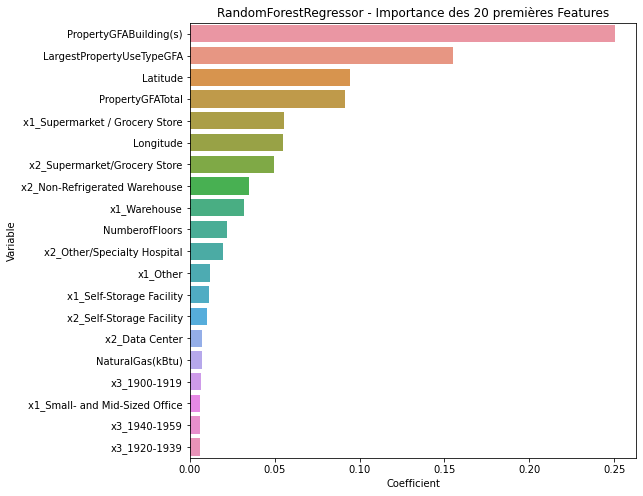

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,8))
plt.title('RandomForestRegressor - Importance des 20 premières Features')
sns.barplot(y = liste_coefs_rer['Variable'].head(20),
            x = liste_coefs_rer['Coefficient'].head(20))
plt.show()

# Intérêt du Energy Star Score

**Séparation X et Y**

In [971]:
X

,BuildingType,PrimaryPropertyType,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),periode
0,NonResidential,Hotel,47.61220,-122.33799,1.0,1.0,88434.0,0.0,88434.0,Hotel,88434.0,0.0,1.0,1.0,1920-1939
1,NonResidential,Hotel,47.61393,-122.33810,1.0,2.2,58895.0,0.0,58895.0,Hotel,57283.0,0.0,1.0,1.0,1960-1979
2,NonResidential,Hotel,47.61412,-122.33664,1.0,1.0,61320.0,0.0,61320.0,Hotel,61320.0,0.0,1.0,1.0,1920-1939
3,Nonresidential COS,Other,47.61623,-122.33657,1.0,2.0,97288.0,0.0,60090.0,Police Station,88830.0,0.0,1.0,1.0,1980-1999
4,NonResidential,Hotel,47.61390,-122.33283,1.0,1.0,83008.0,0.0,83008.0,Hotel,81352.0,0.0,1.0,1.0,1920-1939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,Nonresidential COS,Other,47.69330,-122.37717,1.0,1.0,11968.0,0.0,11968.0,Prison/Incarceration,11968.0,0.0,1.0,1.0,2000-2019
652,Nonresidential COS,Other,47.72126,-122.29735,1.0,1.0,11285.0,0.0,11285.0,Prison/Incarceration,11285.0,0.0,1.0,1.0,1940-1959
653,Nonresidential COS,Other,47.63228,-122.31574,1.0,1.0,23445.0,0.0,23445.0,Other - Recreation,23445.0,0.0,1.0,1.0,1900-1919
654,Nonresidential COS,Other,47.54067,-122.37441,1.0,1.0,18261.0,0.0,18261.0,Other - Recreation,18261.0,0.0,1.0,1.0,1980-1999


In [972]:
X_ess = X.copy()

In [973]:
X_ess['energy_star_score'] = energy_star_score

In [976]:
y_ess = y.copy()
y_ess.drop(X_ess[X_ess['energy_star_score'].isna()].index, inplace=True)

In [977]:
ys_ess = ys.copy()
ys_ess.drop(X_ess[X_ess['energy_star_score'].isna()].index, inplace=True)

In [978]:
X_ess.drop(X_ess[X_ess['energy_star_score'].isna()].index, inplace=True)

**Normalisation & One Hot Encoder**

In [981]:
data['energy_star_score'] = energy_star_score

In [983]:
categorical_columns = data[['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType', 'periode']].columns

numerical_columns = data[['Latitude', 'Longitude','NumberofBuildings', 
        'NumberofFloors', 'PropertyGFATotal','PropertyGFAParking', 
        'PropertyGFABuilding(s)','LargestPropertyUseTypeGFA',
        'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)', 'energy_star_score']].columns

In [984]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

ohe = OneHotEncoder(sparse=False)
ss = StandardScaler()
X_ess[numerical_columns] = ss.fit_transform(X_ess[numerical_columns])
ohe.fit_transform(X_ess[categorical_columns])

X_ess = pd.merge(X_ess[numerical_columns], 
          pd.DataFrame(columns = ohe.get_feature_names().tolist(),
              data = ohe.fit_transform(X_ess[categorical_columns])),
        left_index = True, right_index = True)

Transformation des types des catégories sorties du one hot encoding

In [985]:
import re
regex = re.compile(r'x\d_')
for column in X_ess.columns:
    if regex.search(column):
        X_ess[column] = X_ess[column].astype('int32')

**Séparation du jeu de données(Séparation train/test)**

In [986]:
def equalObs(x, nbin=20):
    nlen = len(x_ess)
    output = np.interp(np.linspace(0, nlen, nbin + 1),
                     np.arange(nlen),
                     np.sort(x))
    output = [elt for elt in output if not np.isnan(elt)]
    output[0] = np.min(x)
    output[-1] = np.max(x)
    output = sorted(list(set(output)))
    
    return output

In [988]:
from sklearn.model_selection import train_test_split
# Diviser les données en ensembles d'entraînement et de test en utilisant ys comme variable de stratification
X_ess_train, X_ess_test, y_ess_train, y_ess_test = \
                        train_test_split(X_ess,
                                         y_ess['SiteEnergyUseWN(kBtu)'], 
                                         test_size = 0.4, 
                                         stratify = ys_ess['SiteEnergyUseWN(kBtu)_quartiles'], 
                                         random_state = 42)


In [989]:
# Calculer les quartiles
quartiles = np.percentile(y_ess_train, np.arange(0, 101, 10))

# Diviser la colonne en quartiles
bins = quartiles
labels = [f"Q{i+1}" for i in range(len(quartiles)-1)]

ys_ess_train = list(pd.cut(y_ess_train, bins=bins, labels=labels))
len(ys_ess_train)

393

**Le meilleur modèle avec ENERGYSTARScore**

In [990]:
# Importation des classes nécessaires
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Initialisation de l'objet RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Définition de la grille de paramètres à tester
params = {"n_estimators": [100, 200, 500],
          "max_depth": [5, 10, 20],
          "min_samples_split": [2, 5, 10],
          "min_samples_leaf": [1, 2, 4]}

# Création de l'objet de validation croisée
kfolds = StratifiedKFold(n_splits=5)

# Recherche des meilleures valeurs pour les hyperparamètres en utilisant GridSearchCV
clf_rf = GridSearchCV(estimator=rf, param_grid=params, scoring='r2', cv=kfolds.split(X_ess_train, ys_ess_train))
clf_rf.fit(X_ess_train, y_ess_train)

# Extraction des résultats de chaque modèle entraîné lors de la validation croisée
cv_results = clf_rf.cv_results_
cv_results_df = pd.DataFrame(cv_results)

# Affichage des résultats
selected_columns = ['mean_test_score', 'std_test_score']
cv_results_selected = cv_results_df[selected_columns]

# Extraction du meilleur modèle
best_model = clf_rf.best_estimator_

    
# Prédiction sur les données de test
y_ess_test_pred = best_model.predict(X_ess_test)


# Évaluation des performances avec la métrique R² sur les données de test
test_r2 = r2_score(y_test, y_test_pred)

# Affichage des résultats
print("Meilleurs hyperparamètres trouvés: ", best_model)
print("Validation score R²: ", cv_results_selected.mean_test_score.max())
print("Test R²: ", test_r2)

Meilleurs hyperparamètres trouvés:  RandomForestRegressor(max_depth=20, n_estimators=500, random_state=42)
Validation score R²:  0.5676622047766932
Test R²:  0.5275574516850379
